In [1]:
import os
import cv2
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

# Environment variable
 

train_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/balanced_train_df.csv'
val_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/balanced_val_df.csv'
test_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/balanced_test_df.csv'

target_size = (224, 224)

# Custom dataset class for mammography data
class MammographyDataset(Dataset):
    def __init__(self, df_path, img_dir, target_size, transform=None):
        self.df = pd.read_csv(df_path)
        self.img_dir = img_dir
        self.target_size = target_size
        self.transform = transform
        self.images, self.metadata, self.labels = self.load_data()

    def load_data(self):
        images, labels = [], []
        age, density = [], []
        
        le_birads = LabelEncoder()  # LabelEncoder for 'breast_birads'
        le_density = LabelEncoder()  # LabelEncoder for 'breast_density'
        
        for _, row in self.df.iterrows():
            img = cv2.imread(os.path.join(self.img_dir, row['image_id']+'.png'))
            if self.transform:
                img = self.transform(img)
            images.append(img)
            labels.append(row['breast_birads'])  # Add breast_birads label
            age.append(float(row['age']))  # Add age
            density.append(row['breast_density'])  # Add breast density

        labels = le_birads.fit_transform(labels)  # Encode breast_birads
        labels = torch.tensor(labels).long()  # Convert labels to tensor
        
        density_encoded = le_density.fit_transform(density)  # Encode breast_density
        density_tensor = torch.tensor(density_encoded).float()  # Convert encoded density to tensor
        
        metadata = {
            'age': torch.tensor(age).float(),  # Convert age to tensor
            'breast_density': density_tensor,  # Use encoded breast_density tensor
        }
        return images, metadata, labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.images[idx], self.metadata['age'][idx], self.metadata['breast_density'][idx], self.labels[idx]


In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

main_img_dir= '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo-PNG-MAMMO-CLIP-CROPPED-TEXT_REMOVE-FLIP-MEDIAN-CLAHE-UNSHARP'
train_dataset = MammographyDataset(train_label, main_img_dir, target_size, transform=transform)
test_dataset = MammographyDataset(test_label, main_img_dir, target_size, transform=transform)
val_dataset = MammographyDataset(val_label, main_img_dir, target_size, transform=transform)


In [3]:
from torch.utils.data import DataLoader

# Tạo DataLoader cho train, val, test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt

# Lấy một batch mẫu từ train_loader
images, age, density, labels = next(iter(train_loader))

# Chọn một mẫu để hiển thị (ở đây chọn mẫu đầu tiên trong batch)
img = images[0].permute(1, 2, 0).numpy()  # Đổi thứ tự từ (C, H, W) thành (H, W, C) để vẽ ảnh
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize the image

metadata = {
    'Age': age[0].item(),
    'Density': density[0].item(),
    'Label': labels[5].item()  # Class label (được mã hóa dưới dạng số nguyên)
}

# Vẽ ảnh
plt.imshow(img)
plt.title(f"Sample Image\nMetadata: {metadata}")
plt.axis('off')
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)  # (batch_size, hidden_dim)
        K = self.key(x)     # (batch_size, hidden_dim)
        V = self.value(x)   # (batch_size, hidden_dim)

        # Tính attention scores và áp dụng softmax
        attention_scores = torch.matmul(Q, K.T) / (K.size(-1) ** 0.5)  # (batch_size, batch_size)
        attention_weights = self.softmax(attention_scores)  # (batch_size, batch_size)

        # Áp dụng attention vào Value
        output = torch.matmul(attention_weights, V)  # (batch_size, hidden_dim)
        return output

class CrossModalityAttention(nn.Module):
    def __init__(self, img_dim, meta_dim, hidden_dim):
        super(CrossModalityAttention, self).__init__()
        self.query_fc = nn.Linear(meta_dim, hidden_dim)
        self.key_fc = nn.Linear(img_dim, hidden_dim)
        self.value_fc = nn.Linear(img_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, img_features, meta_features):
        Q = self.query_fc(meta_features)  # (batch_size, hidden_dim)
        K = self.key_fc(img_features)     # (batch_size, hidden_dim)
        V = self.value_fc(img_features)   # (batch_size, hidden_dim)

        attention_scores = torch.matmul(Q, K.T) / (K.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)

        modality_interaction = torch.matmul(attention_weights, V)  # (batch_size, hidden_dim)
        return modality_interaction

class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()

        # MobileNetV2 cho nhánh ảnh
        self.image_model = models.mobilenet_v2(weights='DEFAULT')
        self.image_model.classifier = nn.Identity()

        # Self-Attention cho nhánh ảnh
        self.self_attention_image = SelfAttention(input_dim=1280, hidden_dim=512)

        # Metadata layers
        self.age_norm = nn.BatchNorm1d(1)
        self.breast_density_emb = nn.Embedding(4, 4)

        # Self-Attention cho nhánh metadata
        self.self_attention_metadata = SelfAttention(input_dim=5, hidden_dim=512)

        # Fully connected layers
        self.fc_image = nn.Linear(512, 512)
        self.fc_metadata = nn.Linear(512, 512)

        # Cross-Modality Attention
        self.cma = CrossModalityAttention(img_dim=512, meta_dim=512, hidden_dim=256)

        # Classification layer
        self.fc_combined = nn.Linear(256, 5)

    def forward(self, x_image, age, breast_density):
        # Xử lý nhánh ảnh
        x_image = self.image_model(x_image)  # (batch_size, 1280)
        x_image = self.self_attention_image(x_image)  # (batch_size, 512)
        x_image = F.relu(self.fc_image(x_image))  # (batch_size, 512)

        # Xử lý nhánh metadata
        age_norm = self.age_norm(age.view(-1, 1))
        breast_density = breast_density.long()
        breast_density_emb = self.breast_density_emb(breast_density)
        metadata = torch.cat([age_norm, breast_density_emb], dim=1)  # (batch_size, 5)
        x_metadata = self.self_attention_metadata(metadata)  # (batch_size, 512)
        x_metadata = F.relu(self.fc_metadata(x_metadata))  # (batch_size, 512)

        # Áp dụng Cross-Modality Attention
        cma_output = self.cma(x_image, x_metadata)  # (batch_size, 256)

        # Phân loại với fully connected layer cuối
        output = self.fc_combined(cma_output)  # (batch_size, 5)
        return output

# # Khởi tạo và kiểm tra mô hình
# model = MultimodalModel()
# x_image = torch.randn(32, 3, 224, 224)  # Batch 32, 3 channels, 224x224
# age = torch.randn(32)  # Tuổi
# breast_density = torch.randint(0, 4, (32,))  # Giá trị breast_density

# # Forward pass
# output = model(x_image, age, breast_density)
# print(f"Output shape: {output.shape}")  # Kết quả: (32, 5)


In [5]:
from tqdm import tqdm 
num_epochs = 2
for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
    images, age, density, labels = batch
    
    # In ra kích thước và giá trị của các tensor
    print("Images shape:", images.shape)
    print("Age shape:", age.shape)
    print("Density shape:", density.shape)
    print("Labels shape:", labels.shape)
    
    # In ra một vài giá trị cụ thể để kiểm tra
    # print("Sample images:", images[0])  # In ra hình ảnh đầu tiên trong batch
    print("Sample age:", age[0])        # In ra giá trị tuổi đầu tiên trong batch
    print("Sample density:", density[0])  # In ra giá trị độ dày đầu tiên trong batch
    print("Sample labels:", labels[0])  # In ra nhãn đầu tiên trong batch

    # Thêm câu lệnh break để chỉ xem một batch đầu tiên
    break


NameError: name 'epoch' is not defined

In [ ]:
# import numpy as np

# # Giả sử bạn đã lấy nhãn từ train_loader
# for batch in train_loader:
#     images, age, density, labels = batch
#     print("Unique labels in the batch:", np.unique(labels.numpy()))



In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm   

 
model = MultimodalModel()   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
 

criterion = nn.CrossEntropyLoss()  # Sử dụng CrossEntropyLoss cho phân loại đa lớp
optimizer = optim.Adam(model.parameters(), lr=1e-4)   

num_epochs = 1

# Bắt đầu quá trình huấn luyện
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_true, train_pred = [], []
 
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, age, density, labels = batch
        images, age, density, labels = (
            images.to(device),
            age.to(device),
            density.to(device),
            labels.to(device)  # Nhãn không cần chuyển đổi sang float
        )

        # Forward pass
        outputs = model(images, age, density)

        # Tính loss
        loss = criterion(outputs, labels)   

        # Dự đoán nhãn
        _, predicted_labels = torch.max(outputs, 1)  # Lấy nhãn có xác suất cao nhất
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted_labels.cpu().numpy())  # Chuyển predicted_labels sang numpy

        # Backward pass và optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Cộng dồn loss cho epoch
        train_loss += loss.item()  # Cộng dồn giá trị loss của batch

    # Tính độ chính xác trên tập train
    train_acc = accuracy_score(train_true, train_pred)
    train_losses.append(train_loss / len(train_loader))  # Trung bình loss
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

Epoch 1/1 [Train]: 100%|██████████████████████████████████████████████████████████████| 411/411 [00:16<00:00, 24.38it/s]

Epoch [1/1], Loss: 1.1269, Train Accuracy: 0.5691


In [7]:
outputs.shape

torch.Size([31, 5])

In [8]:
labels.shape

torch.Size([31])

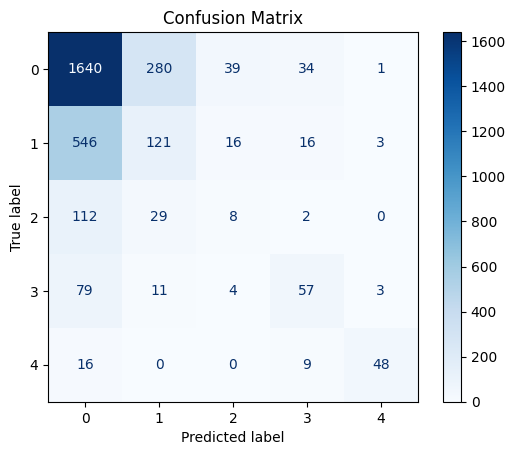

In [13]:
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f}')

In [16]:
# In một mẫu label và output
outputs = model(images, age, density)

# In một mẫu label và output
print("Sample Label:", labels[0].item())  
print("Sample Output:", outputs[0].detach().cpu().numpy())


Sample Label: 0
Sample Output: [ 2.2370865  1.2708278 -0.6064515 -1.2224804 -3.577515 ]


In [21]:
# In một mẫu label và output
outputs = model(images, age, density)

# In một mẫu label và output
print("Sample Label:", labels[2].item())  
print("Sample Output:", outputs[2].detach().cpu().numpy())


Sample Label: 0
Sample Output: [ 1.7648075   0.7781912  -0.18204357 -0.7883264  -3.4617345 ]


Train lần 1


In [8]:
# Khởi tạo mô hình
model = MultimodalModel()   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load trọng số mô hình đã lưu
model.load_state_dict(torch.load('/media/mountHDD2/chuyenmt/Dataset/VinDr-Mammo/Processed/multimodal_model_weights.pth'))

# Đặt mô hình vào chế độ evaluation
model.eval()

print("Model loaded successfully!")

# Bây giờ bạn có thể sử dụng mô hình để đánh giá hoặc dự đoán trên tập dữ liệu test


/tmp/ipykernel_16334/1316474908.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/media/mountHDD2/chuyenmt/Dataset/VinDr-Mammo/Processed

RuntimeError: Error(s) in loading state_dict for MultimodalModel:
	Missing key(s) in state_dict: "cma.query_fc.weight", "cma.query_fc.bias", "cma.key_fc.weight", "cma.key_fc.bias", "cma.value_fc.weight", "cma.value_fc.bias". 
	size mismatch for fc_combined.weight: copying a param with shape torch.Size([5, 1024]) from checkpoint, the shape in current model is torch.Size([5, 256]).

Testing: 100%|██████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 88.80it/s]


Test Loss: 0.9777, Test Accuracy: 0.8699


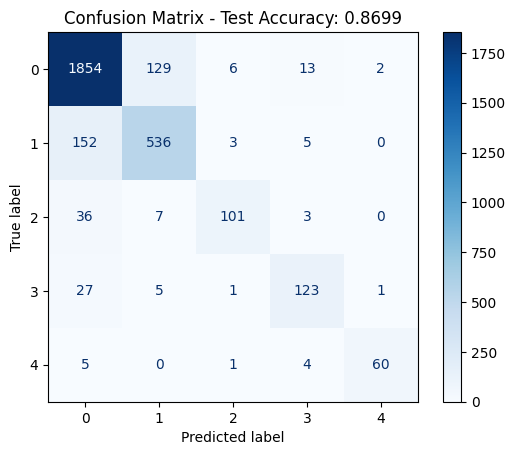

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm   
 

criterion = nn.CrossEntropyLoss()  # Sử dụng CrossEntropyLoss cho phân loại đa lớp
test_loss = 0
test_true, test_pred = [], []

with torch.no_grad():  # Tắt gradient để tăng tốc độ tính toán
    for batch in tqdm(test_loader, desc="Testing"):
        images, age, density, labels = batch
        images, age, density, labels = (
            images.to(device),
            age.to(device),
            density.to(device),
            labels.to(device)
        )

        # Forward pass
        outputs = model(images, age, density)

        # Tính loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()  # Cộng dồn loss

        # Dự đoán nhãn
        _, predicted_labels = torch.max(outputs, 1)
        test_true.extend(labels.cpu().numpy())
        test_pred.extend(predicted_labels.cpu().numpy())

# Tính độ chính xác trên tập test
test_acc = accuracy_score(test_true, test_pred)
test_loss /= len(test_loader)  # Trung bình loss
 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tính toán confusion matrix
conf_matrix = confusion_matrix(test_true, test_pred)

# Initialize lists to store metrics for each class
sensitivity = []
specificity = []
precision = []
accuracy = []

# Calculate metrics for each class
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - (TP + FN + FP)

    sen = TP / (TP + FN) if (TP + FN) != 0 else 0
    spe = TN / (TN + FP) if (TN + FP) != 0 else 0
    ppr = TP / (TP + FP) if (TP + FP) != 0 else 0
    acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    sensitivity.append(sen * 100)
    specificity.append(spe * 100)
    precision.append(ppr * 100)
    accuracy.append(acc * 100)

# Display the results in a table
results_df = pd.DataFrame({
    'Class': [f'C{i+1}' for i in range(len(conf_matrix))],
    'Sensitivity (%)': sensitivity,
    'Specificity (%)': specificity,
    'Precision (%)': precision,
    'Accuracy (%)': accuracy
})

print(results_df)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f}')
plt.show()
 
  


Train lần 2